# Text mining and sentiment analysis 

- Instead, many Net Promoter Score users analyse theme clouds: how often certain words are used in comments. The more frequent the word, the further forward it is in your respondents’ minds.

- This data can be analysed in a number of ways, including but not limited to:

- What the overarching positives and negatives of your customer experience program are.
- How often certain words are used in conjunction with others (providing context).
- What your most valuable customer segments are saying about your brand.
- What your most at risk customer segments are saying about your brand.
- What recurring problems are plaguing multiple customer segments and/or surveys.
- What problems are specific to only certain customer segments.

- These are just a few examples. Theme clouds are versatile in that they can give a broad overview of what your respondents are saying, or can help you dig deep and find specific issues and solutions. In either case, they can quickly and easily inform your future strategy—assuming you use the right analysis tools.



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB,label_binarize,LabelBinarizer
from sklearn.svm import LinearSVC, SVC,libsvm_sparse
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import NMF, LatentDirichletAllocation


from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# import library
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import textblob as tb


from surprise import Reader, Dataset, SVD, evaluate
import warnings; warnings.simplefilter('ignore')
import wordcloud
from wordcloud import WordCloud
import collections


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#social = pd.read_csv('SHINGRIX social mentions 17-Sep-2018.xlsx')
social = pd.read_excel('SHINGRIX social mentions 17-Sep-2018.xlsx')
survey = pd.read_excel('Survey Data.xlsx')
chat=pd.read_excel('US_Transcripts_scrubbed_v2.xlsx')

In [3]:
#social
#social.columns
#chat

In [4]:
# change the column names for easy use
survey1=survey.copy()
survey1 = survey1.rename(columns={'acomment EN': 'comment', 'ANPS (all nps combined)': 'nps_score','end date (-05:00 GMT)':'date_time'})
survey1.head()

,NPS type,country,comment,nps_score,date_time
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46


In [5]:
## create columns with category( promotor, passive, detractor ) base on nps score
def ff(row):
    if row['nps_score']==10 or row['nps_score']==9:
        val='promotors'
    elif row['nps_score']==7 or row['nps_score']==8:
        val='passive'
    else:
        val='detractor'
    return val

In [6]:
survey1['score'] = survey1.apply(ff, axis=1)

In [7]:
survey1.head()

,NPS type,country,comment,nps_score,date_time,score
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor


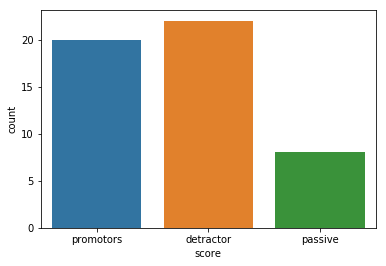

In [8]:
sns.countplot(x='score',data=survey1)

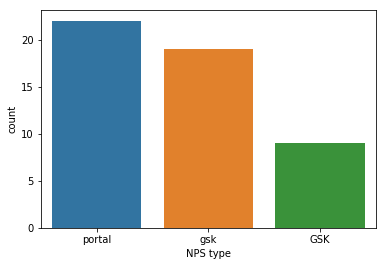

In [9]:
sns.countplot(x='NPS type',data=survey1)

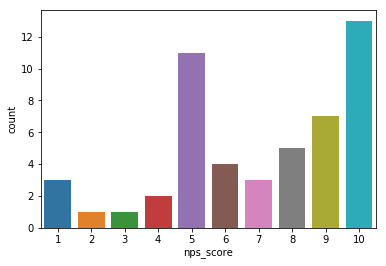

In [10]:
sns.countplot(x='nps_score',data=survey1)

In [11]:
# clean the text
corpus = []
for i in range(0, len(survey1)):
    review = re.sub('[^a-zA-Z]', ' ', survey1['comment'][i]) # match all strings that start with a letter, the second means match all strings that contain a non-letter
    review = review.lower() # lower case
    review = review.split() # split words
    wl = WordNetLemmatizer()  # bettwer way to remove suffix by keping meaning full words
    # remove most common english words in sentece 
    review = [wl.lemmatize(word) for word in review if not word in set(stopwords.words('english'))] # aslo stops most common english words such as a,an, the in ,on etc
    review = ' '.join(review)
    corpus.append(review)
    
#corpus

In [12]:
# function for text preprocessing
def text_processing(row):
    review = re.sub('[^a-zA-Z]', ' ', row['comment']) # match all strings that start with a letter, the second means match all strings that contain a non-letter
    review = review.lower() # lower case
    review = review.split() # split words
    wl = WordNetLemmatizer()  # bettwer way to remove suffix by keping meaning full words
    # remove most common english words in sentece 
    review = [wl.lemmatize(word) for word in review if not word in set(stopwords.words('english'))] # aslo stops most common english words such as a,an, the in ,on etc
    review = ' '.join(review)
    return review

In [13]:
survey1['comment_process'] = survey1.apply(text_processing, axis=1)

In [14]:
survey1

,NPS type,country,comment,nps_score,date_time,score,comment_process
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...
5,portal,United States,the information is very well presented,9,2018-09-18 16:55:54,promotors,information well presented
6,portal,United States,I just don't recommend websites...if a patient...,4,2018-09-14 10:24:56,detractor,recommend website patient need something usual...
7,portal,United States,Ease of use and navigation of the website. Exc...,10,2018-09-13 05:40:11,promotors,ease use navigation website excellent resource...
8,portal,United States,what are the components of the shingrex vaccin...,5,2018-09-12 09:03:21,detractor,component shingrex vaccine grown egg question ...
9,portal,United States,Labels for categories vague. No where on the s...,7,2018-09-11 12:42:32,passive,label category vague site spell abbreviation g...


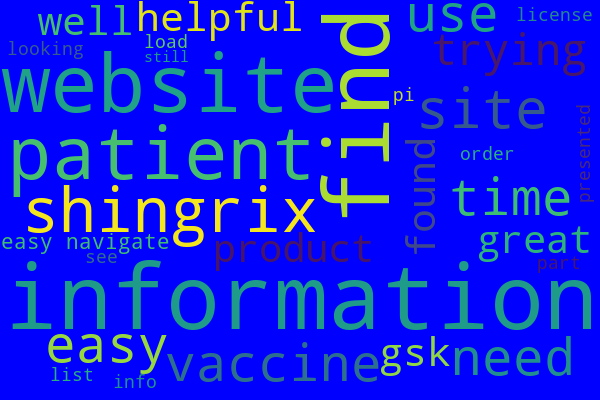

In [15]:
wc=WordCloud(max_words=30, stopwords=None, background_color='blue',width=600, height=400).generate(' '.join(survey1['comment_process']))
wc.to_image()

In [16]:
survey1['comment_process_list'] = survey1['comment_process'].apply(lambda x: x.split())

In [17]:
survey1.head()

,NPS type,country,comment,nps_score,date_time,score,comment_process,comment_process_list
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...,"[easy, navigate, backordered, vaccine, still, ..."
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site,"[expected, information, instead, referred, site]"
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...,"[opportunity, speak, multiple, rep, phone, tra..."
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time,"[found, wanted, minimum, amount, time]"
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...,"[spent, minute, trying, get, website, assign, ..."


In [18]:
# function to generate n-gram
def n_gram(row):
    #ngrm = nltk.bigrams(row['comment_process_list'])
    ngrm = nltk.ngrams(row['comment_process_list'],2) # bigram
    blst = list(ngrm)
    text = ' '.join(['_'.join(i)for i in blst])
    return text

In [19]:
survey1['comment_process_bigram'] = survey1.apply(n_gram, axis=1)

In [20]:
survey1.head()

,NPS type,country,comment,nps_score,date_time,score,comment_process,comment_process_list,comment_process_bigram
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...,"[easy, navigate, backordered, vaccine, still, ...",easy_navigate navigate_backordered backordered...
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site,"[expected, information, instead, referred, site]",expected_information information_instead inste...
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...,"[opportunity, speak, multiple, rep, phone, tra...",opportunity_speak speak_multiple multiple_rep ...
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time,"[found, wanted, minimum, amount, time]",found_wanted wanted_minimum minimum_amount amo...
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...,"[spent, minute, trying, get, website, assign, ...",spent_minute minute_trying trying_get get_webs...


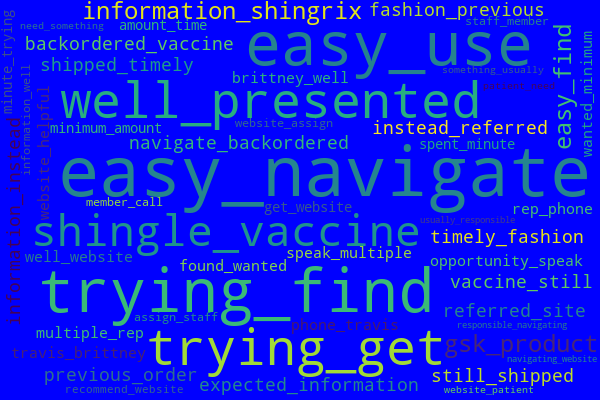

In [21]:
wc=WordCloud(max_words=50, stopwords=None, background_color='blue',width=600, height=400).generate(' '.join(survey1['comment_process_bigram']))
wc.to_image()

In [22]:
survey1

,NPS type,country,comment,nps_score,date_time,score,comment_process,comment_process_list,comment_process_bigram
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...,"[easy, navigate, backordered, vaccine, still, ...",easy_navigate navigate_backordered backordered...
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site,"[expected, information, instead, referred, site]",expected_information information_instead inste...
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...,"[opportunity, speak, multiple, rep, phone, tra...",opportunity_speak speak_multiple multiple_rep ...
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time,"[found, wanted, minimum, amount, time]",found_wanted wanted_minimum minimum_amount amo...
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...,"[spent, minute, trying, get, website, assign, ...",spent_minute minute_trying trying_get get_webs...
5,portal,United States,the information is very well presented,9,2018-09-18 16:55:54,promotors,information well presented,"[information, well, presented]",information_well well_presented
6,portal,United States,I just don't recommend websites...if a patient...,4,2018-09-14 10:24:56,detractor,recommend website patient need something usual...,"[recommend, website, patient, need, something,...",recommend_website website_patient patient_need...
7,portal,United States,Ease of use and navigation of the website. Exc...,10,2018-09-13 05:40:11,promotors,ease use navigation website excellent resource...,"[ease, use, navigation, website, excellent, re...",ease_use use_navigation navigation_website web...
8,portal,United States,what are the components of the shingrex vaccin...,5,2018-09-12 09:03:21,detractor,component shingrex vaccine grown egg question ...,"[component, shingrex, vaccine, grown, egg, que...",component_shingrex shingrex_vaccine vaccine_gr...
9,portal,United States,Labels for categories vague. No where on the s...,7,2018-09-11 12:42:32,passive,label category vague site spell abbreviation g...,"[label, category, vague, site, spell, abbrevia...",label_category category_vague vague_site site_...


In [24]:
# select only promotor, detractor, and passive comments separatly 
survey1_promotor=survey1[survey1['score']=='promotors'][['NPS type','nps_score','score','comment_process']]
survey1_detractor=survey1[survey1['score']=='detractor'][['NPS type','nps_score','score','comment_process']]
survey1_passive=survey1[survey1['score']=='passive'][['NPS type','nps_score','score','comment_process']]


survey1_passive

,NPS type,nps_score,score,comment_process
9,portal,7,passive,label category vague site spell abbreviation g...
12,portal,8,passive,need faq section patient get nd injection per ...
27,gsk,8,passive,definition month day r day
30,portal,8,passive,fairly easy navigate toolbars top left hand si...
33,GSK,7,passive,hard time finding package insert pi shingrix l...
34,GSK,8,passive,easy use clear info could find long experience...
38,portal,8,passive,trying find vaccine ok asymptomatic hiv patient
42,portal,7,passive,found heading always expected


In [32]:
## bar plot of the frequesncy of the words
#cv = CountVectorizer(max_features = 1000)
cv = CountVectorizer(ngram_range=(2,2))

bow = cv.fit_transform(survey1_promotor['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_prom = pd.DataFrame(word_counter.most_common(), columns = ['word', 'freq'])

bow = cv.fit_transform(survey1_passive['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_pass = pd.DataFrame(word_counter.most_common(), columns = ['word', 'freq'])

bow = cv.fit_transform(survey1_detractor['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_detra = pd.DataFrame(word_counter.most_common(), columns = ['word', 'freq'])

# combined the dataframe 
word_counter_final=pd.concat([word_counter_prom,word_counter_pass,word_counter_detra],keys=['promotor','passive','detractor'],names=['Series name', 'Row ID'])
word_counter_final1=word_counter_final.reset_index(level=['Series name','Row ID'])

# plots
#fig, ax = plt.subplots(figsize=(12, 10))
#sns.catplot(x="word", y="freq", data=word_counter_final1,kind='bar',hue='Series name',hue_order=['promotor', 'process','detractor'])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40,fontsize=10,ha="right")
#ax.despine(left=True)
#plt.show();

#word_counter_final.head()

In [105]:
word_counter_final1.head(100)

,Series name,Row ID,word,freq
0,promotor,0,easy navigate,3
1,promotor,1,easy find,2
2,promotor,2,easy use,2
3,promotor,3,well presented,2
4,promotor,4,ago fine,1
5,promotor,5,also recommended,1
6,promotor,6,always find,1
7,promotor,7,amount time,1
8,promotor,8,backordered vaccine,1
9,promotor,9,brittney well,1


In [34]:
# save in csv file in local directory 
word_counter_final1.to_csv('word_freq_bigram_list.csv')

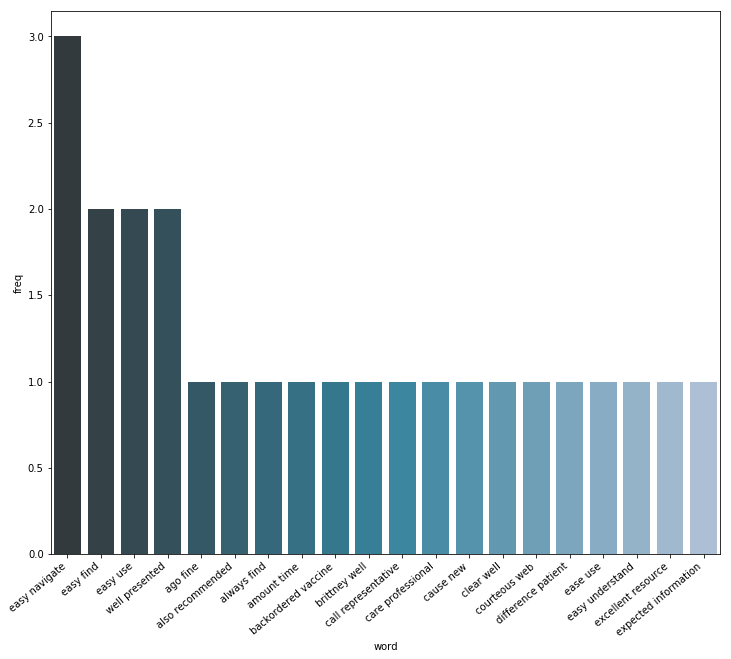

In [29]:
## bar plot of the frequesncy of the words
#cv = CountVectorizer(max_features = 1000)
#tf = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, ngram_range=(1, 2))

cv = CountVectorizer(ngram_range=(2,2))
bow = cv.fit_transform(survey1_promotor['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
ax=sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,fontsize=10,ha="right")
plt.show();

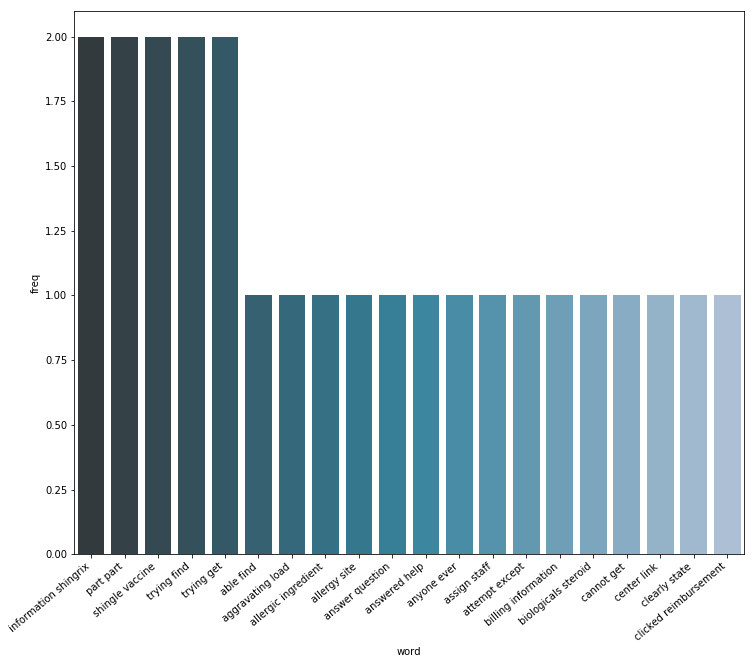

In [30]:
## bar plot of the frequesncy of the words
#cv = CountVectorizer(max_features = 1000)
cv = CountVectorizer(ngram_range=(2,2))
bow = cv.fit_transform(survey1_detractor['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
ax=sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,fontsize=10,ha="right")
plt.show();

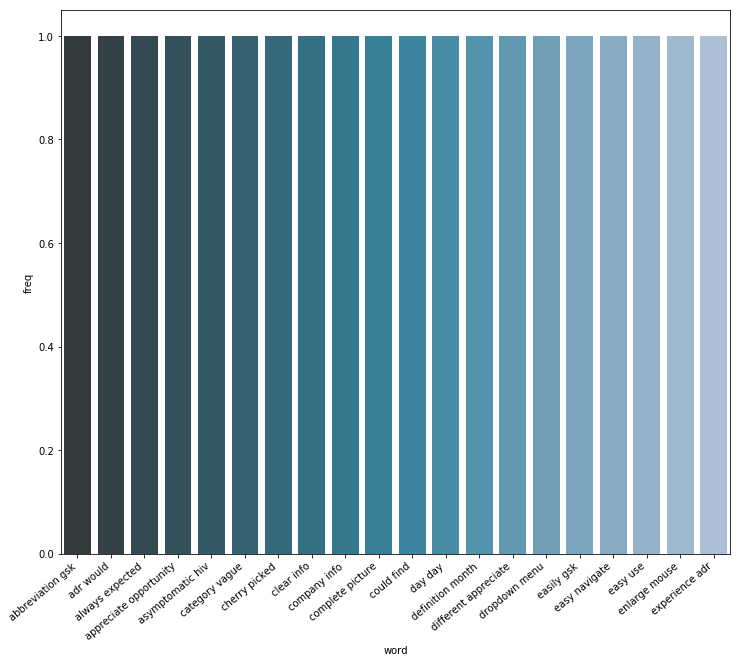

In [31]:
## bar plot of the frequesncy of the words
#cv = CountVectorizer(max_features = 1000)
cv = CountVectorizer(ngram_range=(2,2))
bow = cv.fit_transform(survey1_passive['comment_process'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
ax=sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,fontsize=10,ha="right")
plt.show();

# sentiment classification model

In [35]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = survey1['score'].values

In [36]:
# Bag of words model with ngram 
cv = CountVectorizer(ngram_range=(1,2))
#X = cv.fit_transform(df['content'])
X = cv.fit_transform(corpus).toarray()
y = survey1['score'].values

In [37]:
# TF-IDF vectorization ( with bigram )
# considering bigram, and removing most common english words
#tf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tf = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, ngram_range=(1, 2))
X = tf.fit_transform(survey1['comment_process']).toarray()
y = survey1['score'].values

In [38]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## model creation
classifier = GaussianNB() #  Naive Bayes
#classifier = LogisticRegression(random_state=0,solver='lbfgs',class_weight='balanced',multi_class='multinomial')
#classifier = LogisticRegression(random_state=0,class_weight='balanced')
#classifier=LinearSVC(class_weight='balanced')
#classifier= RandomForestClassifier()

## fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


             precision    recall  f1-score   support

  promotors       0.67      0.50      0.57         4
  detractor       0.20      0.50      0.29         2
    passive       0.50      0.25      0.33         4

avg / total       0.51      0.40      0.42        10



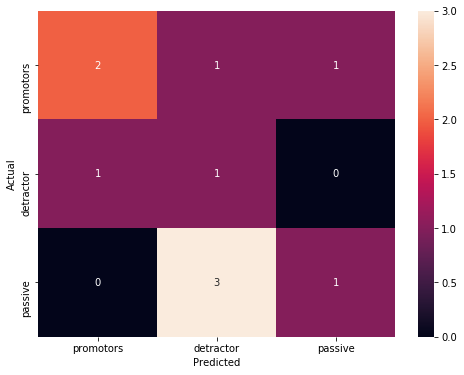

In [39]:
# matrix to measure classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix

class_names=survey1['score'].unique()


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))


# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sentiment analysis 

- using Vader library

In [40]:
#pip install vaderSentiment

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [42]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [107]:
sentiment_analyzer_scores('I like that Corvette.')
sentiment_analyzer_scores('I am trying to get to the list of insurance coverage for shingles vaccine but it will not load. I was told there was a form that would help be see if a patients insurance will cover shingrix, But I cannot get to it')

I like that Corvette.------------------- {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
I am trying to get to the list of insurance coverage for shingles vaccine but it will not load. I was told there was a form that would help be see if a patients insurance will cover shingrix, But I cannot get to it {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.5499}


# Survay data

In [47]:
survey1

,NPS type,country,comment,nps_score,date_time,score,comment_process,comment_process_list,comment_process_bigram
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...,"[easy, navigate, backordered, vaccine, still, ...",easy_navigate navigate_backordered backordered...
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site,"[expected, information, instead, referred, site]",expected_information information_instead inste...
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...,"[opportunity, speak, multiple, rep, phone, tra...",opportunity_speak speak_multiple multiple_rep ...
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time,"[found, wanted, minimum, amount, time]",found_wanted wanted_minimum minimum_amount amo...
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...,"[spent, minute, trying, get, website, assign, ...",spent_minute minute_trying trying_get get_webs...
5,portal,United States,the information is very well presented,9,2018-09-18 16:55:54,promotors,information well presented,"[information, well, presented]",information_well well_presented
6,portal,United States,I just don't recommend websites...if a patient...,4,2018-09-14 10:24:56,detractor,recommend website patient need something usual...,"[recommend, website, patient, need, something,...",recommend_website website_patient patient_need...
7,portal,United States,Ease of use and navigation of the website. Exc...,10,2018-09-13 05:40:11,promotors,ease use navigation website excellent resource...,"[ease, use, navigation, website, excellent, re...",ease_use use_navigation navigation_website web...
8,portal,United States,what are the components of the shingrex vaccin...,5,2018-09-12 09:03:21,detractor,component shingrex vaccine grown egg question ...,"[component, shingrex, vaccine, grown, egg, que...",component_shingrex shingrex_vaccine vaccine_gr...
9,portal,United States,Labels for categories vague. No where on the s...,7,2018-09-11 12:42:32,passive,label category vague site spell abbreviation g...,"[label, category, vague, site, spell, abbrevia...",label_category category_vague vague_site site_...


In [57]:
# write sentiment generation function using vander sentiment library
def sentiment_analyzer_scores1(sentence):
    score = analyser.polarity_scores(sentence)
    return score


# function to convert compound score to nps category
def compound_to_nps_cat(row):
    if row['compound_score']>=0.05:
        val='positive'
    elif row['compound_score']<=-0.05:
        val='negative'
    else:
        val='nutral'
    return val


survey1['sentiments']=survey1['comment'].apply(sentiment_analyzer_scores1)
survey1['compound_score']=survey1['sentiments'].apply(lambda raw:raw['compound'])


survey1['sentiment_pred']=survey1.apply(compound_to_nps_cat,axis=1)
survey1.head()

,NPS type,country,comment,nps_score,date_time,score,comment_process,comment_process_list,comment_process_bigram,sentiments,compound_score,sentiment_pred
0,portal,United States,very easy to navigate-\nour backordered vaccin...,10,2018-09-27 16:28:39,promotors,easy navigate backordered vaccine still shippe...,"[easy, navigate, backordered, vaccine, still, ...",easy_navigate navigate_backordered backordered...,"{'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'comp...",0.4927,positive
1,gsk,United States,EXPECTED MORE INFORMATION INSTEAD OF BEING REF...,9,2018-09-27 15:14:59,promotors,expected information instead referred site,"[expected, information, instead, referred, site]",expected_information information_instead inste...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,nutral
2,portal,United States,I have had the opportunity to speak with multi...,10,2018-09-26 10:39:10,promotors,opportunity speak multiple rep phone travis br...,"[opportunity, speak, multiple, rep, phone, tra...",opportunity_speak speak_multiple multiple_rep ...,"{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...",0.8346,positive
3,gsk,United States,FOUND WHAT I WANTED IN MINIMUM AMOUNT OF TIME,10,2018-09-25 16:07:10,promotors,found wanted minimum amount time,"[found, wanted, minimum, amount, time]",found_wanted wanted_minimum minimum_amount amo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,nutral
4,gsk,United States,I spent 10 minutes just trying to get into the...,5,2018-09-24 15:25:46,detractor,spent minute trying get website assign staff m...,"[spent, minute, trying, get, website, assign, ...",spent_minute minute_trying trying_get get_webs...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,nutral


In [63]:
survey2=survey1[['comment','nps_score','score','compound_score','sentiment_pred']]
survey2.to_csv('survay_sentiment_pred.csv')

In [611]:
from sklearn.metrics import confusion_matrix

In [65]:
print(survey1.score.unique())
print(survey1.sentiment_pred.unique())

['promotors' 'detractor' 'passive']
['positive' 'nutral' 'negative']


In [66]:
'''

from sklearn.metrics import confusion_matrix

y_true=survey1.score
y_pred=survey1.nps_cat_pred
class_names=survey1.nps_cat_pred.unique() 

conf_mat=confusion_matrix(y_true, y_pred)
# print classification scores 
print(metrics.classification_report(y_true, y_pred,target_names=class_names))


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

'''


"\n\nfrom sklearn.metrics import confusion_matrix\n\ny_true=survey1.score\ny_pred=survey1.nps_cat_pred\nclass_names=survey1.nps_cat_pred.unique() \n\nconf_mat=confusion_matrix(y_true, y_pred)\n# print classification scores \nprint(metrics.classification_report(y_true, y_pred,target_names=class_names))\n\n\nfig, ax = plt.subplots(figsize=(8,6))\nsns.heatmap(conf_mat, annot=True, fmt='d',\n            xticklabels=class_names, yticklabels=class_names)\nplt.ylabel('Actual')\nplt.xlabel('Predicted')\nplt.show()\n\n"

In [67]:
survey1['score'].value_counts()

detractor    22
promotors    20
passive       8
Name: score, dtype: int64

In [68]:
survey1['sentiment_pred'].value_counts()

positive    29
nutral      15
negative     6
Name: sentiment_pred, dtype: int64

# Social media data

In [69]:
social1=social.copy()

In [70]:
social1.columns

Index(['UniversalMessageId', 'SocialNetwork', 'SenderUserId',
       'SenderScreenName', 'SenderListedName', 'SenderProfileImgUrl',
       'SenderProfileLink', 'Sender Followers Count', 'SenderInfluencerScore',
       'SenderAge', 'SenderGender', 'Title', 'Message', 'MessageType',
       'CreatedTime', 'Language', 'LanguageCode', 'CountryCode',
       'MediaTypeList', 'Permalink', 'Domain', 'Retweets', 'Tweet Generator',
       'Favorites', 'ReceiverId', 'ReceiverScreenName', 'AssignedBy',
       'AssignedTo', 'Spam', 'Status', 'Priority', 'Sentiment', 'ClientQueues',
       'PartnerQueues', 'ClientCustomProps', 'PartnerCustomProps',
       'Custom Tags', 'Action Time', 'Method (Hidden field)',
       'Contact Source (Hidden field)', 'Business Unit', 'Country',
       'Business Area', 'Case Owner Country', 'Message Source', 'Brand',
       'Issue', 'Brand Reply', 'Reason for No Reply', 'Franchise', 'Audience',
       'Escalated?', 'Social Engagement POC Brand', 'Geo Target', 'Post Id',

In [71]:
def sentiment_analyzer_scores1(sentence):
    score = analyser.polarity_scores(sentence['Message'])
    return score

# function to convert compound score to nps category
def compound_to_nps_cat(row):
    if row['compound_score']>=0.05:
        val='POSITIVE'
    elif row['compound_score']<=-0.05:
        val='NEGATIVE'
    else:
        val='NEUTRAL'
    return val

social2=social1.dropna(subset=['Message']) # remove nan from Message column by droping row
social2['sentiment_scores']=social2.apply(sentiment_analyzer_scores1,axis=1)
social2['compound_score']=social2['sentiment_scores'].apply(lambda raw:raw['compound'])
social2['sentiment_pred']=social2.apply(compound_to_nps_cat,axis=1)


In [95]:
# save as csv file
social3=social2[['Message','Sentiment','compound_score','sentiment_pred']]
social3.to_csv('social_sentiment_pred.csv')
social3.head()

,Message,Sentiment,compound_score,sentiment_pred
0,Normally a flu shot does not bother me too muc...,NEGATIVE,-0.4145,NEGATIVE
1,@chadinabhan @WilliamDale_MD @adamcifu @oncolo...,POSITIVE,0.0000,NEUTRAL
2,Are you recommending Shingrix to all adults > ...,NEUTRAL,0.0000,NEUTRAL
3,Dear @GSK re: your Shingrix vaccine supply pro...,NEUTRAL,-0.4215,NEGATIVE
4,I'll be more aspirational than the usual Debbi...,NEUTRAL,0.3400,POSITIVE


In [96]:
social3['Sentiment'].value_counts()

NEUTRAL     904
NEGATIVE    266
POSITIVE    111
Name: Sentiment, dtype: int64

In [97]:
social3['sentiment_pred'].value_counts()

POSITIVE    624
NEGATIVE    430
NEUTRAL     227
Name: sentiment_pred, dtype: int64

             precision    recall  f1-score   support

   NEGATIVE       0.41      0.66      0.51       266
   POSITIVE       0.77      0.19      0.31       904
    NEUTRAL       0.13      0.72      0.22       111

avg / total       0.64      0.34      0.34      1281



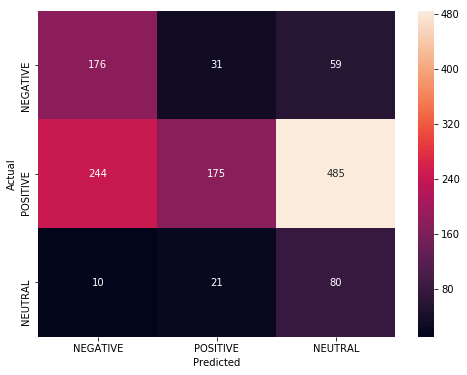

In [98]:
y_true=social2.Sentiment
y_pred=social2.sentiment_pred
conf_mat=confusion_matrix(y_true, y_pred)
class_names=social2.Sentiment.unique() 


# print classification scores 
print(metrics.classification_report(y_true, y_pred,target_names=class_names))


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Chat data

In [100]:
chat1=chat.copy()
chat1.head()

,Date,Chat ID,Duration,Operator,Customer
0,07/19/2018,003B1C80C7,00:09:37,Hello Bharath welcome to Live Chat. My name is...,NaN
1,08/17/2018,00805040E4,00:07:04,Hello Robin welcome to Live Chat. My name is T...,Medical Assistant Modoc Medical Clinic **NUM**...
2,08/29/2018,00AED030F0,00:18:18,"Hello, Stephanie Wills, welcome to Live Chat. ...","Pharmacist, **NUM**, **NUM**, **USER EMAIL** ~..."
3,07/23/2018,00B41CB0CB,00:21:13,Hello Karol SNyder. Welcome to Live Chat. My...,what is the time frame between Bexsero its say...
4,09/11/2018,00C023C0FD,00:18:29,Hello Carolyn Burnham welcome to Live Chat. My...,I'm a pharmacist. My zip is **NUM**. Phone is ...


In [101]:
def sentiment_analyzer_scores1(sentence):
    score = analyser.polarity_scores(sentence['Customer'])
    return score


# function to convert compound score to nps category
def compound_to_nps_cat(row):
    if row['compound_score']>=0.05:
        val='POSITIVE'
    elif row['compound_score']<=-0.05:
        val='NEGATIVE'
    else:
        val='NEUTRAL'
    return val

chat1=chat1.dropna(subset=['Customer']) # remove nan from Customer column by droping row
chat1['sentiment_scores']=chat1.apply(sentiment_analyzer_scores1,axis=1)
chat1['compound_score']=chat1['sentiment_scores'].apply(lambda raw:raw['compound'])
chat1['sentiment_pred']=chat1.apply(compound_to_nps_cat,axis=1)


In [102]:
chat1.head()

,Date,Chat ID,Duration,Operator,Customer,sentiment_scores,compound_score,sentiment_pred
1,08/17/2018,00805040E4,00:07:04,Hello Robin welcome to Live Chat. My name is T...,Medical Assistant Modoc Medical Clinic **NUM**...,"{'neg': 0.025, 'neu': 0.83, 'pos': 0.145, 'com...",0.9224,POSITIVE
2,08/29/2018,00AED030F0,00:18:18,"Hello, Stephanie Wills, welcome to Live Chat. ...","Pharmacist, **NUM**, **NUM**, **USER EMAIL** ~...","{'neg': 0.062, 'neu': 0.73, 'pos': 0.208, 'com...",0.9586,POSITIVE
3,07/23/2018,00B41CB0CB,00:21:13,Hello Karol SNyder. Welcome to Live Chat. My...,what is the time frame between Bexsero its say...,"{'neg': 0.0, 'neu': 0.962, 'pos': 0.038, 'comp...",0.2960,POSITIVE
4,09/11/2018,00C023C0FD,00:18:29,Hello Carolyn Burnham welcome to Live Chat. My...,I'm a pharmacist. My zip is **NUM**. Phone is ...,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.9934,POSITIVE
5,08/07/2018,00CA2360DA,00:37:56,"Hello, Kim Bailey, welcome to Live Chat. My na...",I'm a nurse ~ \nzip code **NUM** ~ \nphone num...,"{'neg': 0.035, 'neu': 0.813, 'pos': 0.152, 'co...",0.9609,POSITIVE


In [103]:
chat2=chat1[['Operator','Customer','compound_score','sentiment_pred']]
chat2.head()
chat2.to_csv('chat_customer_sentiment_pred.csv')

In [104]:
chat1.sentiment_pred.value_counts()

POSITIVE    1261
NEUTRAL      106
NEGATIVE      90
Name: sentiment_pred, dtype: int64